In [30]:
#Import Libraries

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.linear_model import Ridge, LinearRegression
from sklearn.preprocessing import scale, StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.tree import DecisionTreeRegressor
from sklearn import tree
import seaborn
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn import preprocessing
import graphviz

In [2]:
# Load datasets
salary_potential= pd.read_csv("/salary_potential.csv")
diversity_school = pd.read_csv("/diversity_school.csv")
tuition_income = pd.read_csv('/tuition_income.csv')
tuition_cost = pd.read_csv('/tuition_cost.csv')

In [3]:
# Drop unkown/missing variables
salary_potential = salary_potential.dropna()
diversity_school = diversity_school.dropna()
tuition_income = tuition_income.dropna()
tuition_cost = tuition_cost.dropna()

# Datasets

In [4]:
# Glimpse of datasets
salary_potential.head()

,rank,name,state_name,early_career_pay,mid_career_pay,make_world_better_percent,stem_percent
0,1,Auburn University,Alabama,54400,104500,51.0,31
1,2,University of Alabama in Huntsville,Alabama,57500,103900,59.0,45
2,3,The University of Alabama,Alabama,52300,97400,50.0,15
3,4,Tuskegee University,Alabama,54500,93500,61.0,30
4,5,Samford University,Alabama,48400,90500,52.0,3


In [5]:
diversity_school.head()

,name,total_enrollment,state,category,enrollment
0,University of Phoenix-Arizona,195059,Arizona,Women,134722
1,University of Phoenix-Arizona,195059,Arizona,American Indian / Alaska Native,876
2,University of Phoenix-Arizona,195059,Arizona,Asian,1959
3,University of Phoenix-Arizona,195059,Arizona,Black,31455
4,University of Phoenix-Arizona,195059,Arizona,Hispanic,13984


In [6]:
tuition_income.head()

,name,state,total_price,year,campus,net_cost,income_lvl
0,Piedmont International University,NC,20174,2016,On Campus,11475.00000,"0 to 30,000"
1,Piedmont International University,NC,20174,2016,On Campus,11451.00000,"30,001 to 48,000"
2,Piedmont International University,NC,20174,2016,On Campus,16229.00000,"48_001 to 75,000"
3,Piedmont International University,NC,20174,2016,On Campus,15592.00000,"75,001 to 110,000"
4,Piedmont International University,NC,20514,2017,On Campus,11668.39249,"0 to 30,000"


In [7]:
tuition_cost.head()

,name,state,state_code,type,degree_length,room_and_board,in_state_tuition,in_state_total,out_of_state_tuition,out_of_state_total
1,Abilene Christian University,Texas,TX,Private,4 Year,10350.0,34850,45200,34850,45200
2,Abraham Baldwin Agricultural College,Georgia,GA,Public,2 Year,8474.0,4128,12602,12550,21024
4,Academy of Art University,California,CA,For Profit,4 Year,16648.0,27810,44458,27810,44458
5,Adams State University,Colorado,CO,Public,4 Year,8782.0,9440,18222,20456,29238
6,Adelphi University,New York,NY,Private,4 Year,16030.0,38660,54690,38660,54690


# Data Processing

We will use *early_career_pay* and *stem_percent* from the **salary_potential** table, calculate the proportion of women using women enrollment and total enrollment from the **diversity_school** table, *net_cost* from **tuition_income**, and *in_state_total* & *out_of_state_total* from the **tuition_cost** dataset.

In [8]:
salary_potential = salary_potential[['name', 'early_career_pay', 'stem_percent']]
salary_potential

,name,early_career_pay,stem_percent
0,Auburn University,54400,31
1,University of Alabama in Huntsville,57500,45
2,The University of Alabama,52300,15
3,Tuskegee University,54500,30
4,Samford University,48400,3
...,...,...,...
930,Viterbo University,46800,3
931,Concordia University-Wisconsin,46700,9
932,University of Wisconsin-Parkside,46000,17
933,University of Wisconsin-River Falls,47100,14


We want colleges with total enrollment of at least 2000 to mitigate the influence of outliers on our predicton.

In [9]:
# Filter colleges with total enrollment of at least 2000 (the total enrollment at MHC is approx. 2200)

diversity_school = diversity_school[diversity_school['total_enrollment'] > 2000]
diversity_school

,name,total_enrollment,state,category,enrollment
0,University of Phoenix-Arizona,195059,Arizona,Women,134722
1,University of Phoenix-Arizona,195059,Arizona,American Indian / Alaska Native,876
2,University of Phoenix-Arizona,195059,Arizona,Asian,1959
3,University of Phoenix-Arizona,195059,Arizona,Black,31455
4,University of Phoenix-Arizona,195059,Arizona,Hispanic,13984
...,...,...,...,...,...
21456,Dominican University of California,2001,California,White,783
21457,Dominican University of California,2001,California,Two Or More Races,78
21458,Dominican University of California,2001,California,Unknown,306
21459,Dominican University of California,2001,California,Non-Resident Foreign,40


In [10]:
diversity_school['category'].unique()

array(['Women', 'American Indian / Alaska Native', 'Asian', 'Black',
       'Hispanic', 'Native Hawaiian / Pacific Islander', 'White',
       'Two Or More Races', 'Unknown', 'Non-Resident Foreign',
       'Total Minority'], dtype=object)

Instead of using *category* that has different ethinic and gender groups as our variables, we want to create new variables called *women_proportion* and *foreign_proportion* to represent the respective proportions of women and the foreign population.

In [11]:
# take rows that consist category 'Women' and 'Non-Resident Foreign'
women = diversity_school[diversity_school['category'] == 'Women']
foreign = diversity_school[diversity_school['category'] == 'Non-Resident Foreign']

# make a new table; proportions of each categories
women_prop_df = pd.DataFrame({'name': women['name'],
                            'women_proportion': (women['enrollment']/women['total_enrollment'])})

foreign_prop_df = pd.DataFrame({'name': foreign['name'],
                             'foreign_proportion': (foreign['enrollment']/foreign['total_enrollment'])})
women_prop_df.head()

,name,women_proportion
0,University of Phoenix-Arizona,0.690673
11,Ivy Tech Community College-Central Indiana,0.586495
22,Liberty University,0.593292
33,Lone Star College system,0.594683
44,Miami Dade College,0.580247


In [12]:
foreign_prop_df.head()

,name,foreign_proportion
9,University of Phoenix-Arizona,0.017200
20,Ivy Tech Community College-Central Indiana,0.000263
31,Liberty University,0.012718
42,Lone Star College system,0.018719
53,Miami Dade College,0.051298


In [13]:
# merge the new women_prop_df and foreign_prop_df to the original diversity dataset
diversity_school = diversity_school.merge(women_prop_df, on = 'name').merge(foreign_prop_df, on = 'name')
diversity_school.head()

,name,total_enrollment,state,category,enrollment,women_proportion,foreign_proportion
0,University of Phoenix-Arizona,195059,Arizona,Women,134722,0.690673,0.0172
1,University of Phoenix-Arizona,195059,Arizona,American Indian / Alaska Native,876,0.690673,0.0172
2,University of Phoenix-Arizona,195059,Arizona,Asian,1959,0.690673,0.0172
3,University of Phoenix-Arizona,195059,Arizona,Black,31455,0.690673,0.0172
4,University of Phoenix-Arizona,195059,Arizona,Hispanic,13984,0.690673,0.0172


In [14]:
# drop all unused variables and drop duplicates
diversity_school = diversity_school.drop(['state', 'category', 'enrollment'], axis = 1).groupby(['name']).first().reset_index()
diversity_school.head()

,name,total_enrollment,women_proportion,foreign_proportion
0,A.T. Still University of Health Sciences,3226,0.558896,0.016429
1,ASA Institute of Business and Computer Technology,4624,0.626514,0.153547
2,Abilene Christian University,4427,0.578721,0.041789
3,Abraham Baldwin Agricultural College,3458,0.526894,0.014170
4,Academy of Art University,15212,0.579477,0.340060


Choose *net_cost* from the **tuition_income** dataset, and *in_state_total* & *out_of_state_total* from the **tuition_cost** dataset. *name* variable is selected to be used for merging all four datasets.

In [15]:
tuition_cost = tuition_cost[['name', 'type', 'in_state_total', 'out_of_state_total']]
tuition_cost.head()

,name,type,in_state_total,out_of_state_total
1,Abilene Christian University,Private,45200,45200
2,Abraham Baldwin Agricultural College,Public,12602,21024
4,Academy of Art University,For Profit,44458,44458
5,Adams State University,Public,18222,29238
6,Adelphi University,Private,54690,54690


In [16]:
tuition_income = tuition_income[['name','net_cost']].groupby(['name']).first().round(2).reset_index()
tuition_income.head()

,name,net_cost
0,AI Miami International University of Art and D...,23774.0
1,ASA College,20916.0
2,ATA Career Education,18158.0
3,ATA College,25437.0
4,Aaniiih Nakoda College,9383.0


Merge all processed datasets into one and name it "college".

In [17]:
college = salary_potential.merge(
    right = diversity_school, on = 'name').merge(
        right = tuition_income, on = 'name').merge(
            right = tuition_cost, on = 'name')
college.head()

,name,early_career_pay,stem_percent,total_enrollment,women_proportion,foreign_proportion,net_cost,type,in_state_total,out_of_state_total
0,Auburn University,54400,31,25912,0.493902,0.055071,11380.0,Public,24608,43856
1,Tuskegee University,54500,30,3103,0.597809,0.006445,25876.0,Private,31820,31820
2,Samford University,48400,3,4933,0.624772,0.031016,14826.0,Private,42200,42200
3,University of Alabama at Birmingham,48600,17,18698,0.603701,0.035565,12457.0,Public,17110,31030
4,University of South Alabama,47700,17,15805,0.613730,0.042202,8972.0,Public,17490,27360


# Exploratory Data Analysis & Visualization

In [18]:
n_samples, n_features = college.shape

print('Number of samples:', n_samples)
print('Number of features:', n_features)

Number of samples: 444
Number of features: 10


**Covariance** Matrix --- compare correlations between parameters

In [19]:
college_for_matrix = college[['total_enrollment', 'women_proportion', 'foreign_proportion', 'early_career_pay',
       'net_cost', 'stem_percent', 'in_state_total',
       'out_of_state_total']]
corr_matrix = college_for_matrix.corr()
corr_matrix['early_career_pay'].sort_values(ascending=False)

early_career_pay      1.000000
out_of_state_total    0.723961
stem_percent          0.687762
in_state_total        0.631743
foreign_proportion    0.580553
net_cost              0.166416
total_enrollment      0.161157
women_proportion     -0.524711
Name: early_career_pay, dtype: float64

In [40]:
college_for_matrix = college[['women_proportion', 'foreign_proportion', 'early_career_pay',
       'net_cost', 'stem_percent', 'in_state_total',
       'out_of_state_total']]
corr_matrix = college_for_matrix.corr()
corr_matrix['early_career_pay'].sort_values(ascending=False)

early_career_pay      1.000000
out_of_state_total    0.723961
stem_percent          0.687762
in_state_total        0.631743
foreign_proportion    0.580553
net_cost              0.166416
women_proportion     -0.524711
Name: early_career_pay, dtype: float64

*   **Strong Positive Correlations**: *out_of_state_total*, *stem_percent*, *in_state_total*. These suggest that with higher early career pay tend to have higher costs for out-of-state students, a higher proportion of students in STEM fields, and higher costs for in-state students.                         

*   **Moderate Positive Correlation**: *Foreign_Proportion*, suggesting that colleges with higher early career pay tend to have a higher proportion international students.

*   **Weak Positive Correlations**: *net_cost*, *total_enrollment*, suggests that there is a slight tendency for colleges with higher early career pay to have higher net costs of attendance after scholarship/financial aid and a larger enrollments.

*   **Strong Negative Correlation**: *women_proportion*, strong negative correlation between early career pay and the proportion of female students, suggesting that colleges with higher early career pay tend to have a lower proportion of female students.

A barplot of mean early career pay for public and private institutions. A comparison of the average early career pay between the two types of institutions

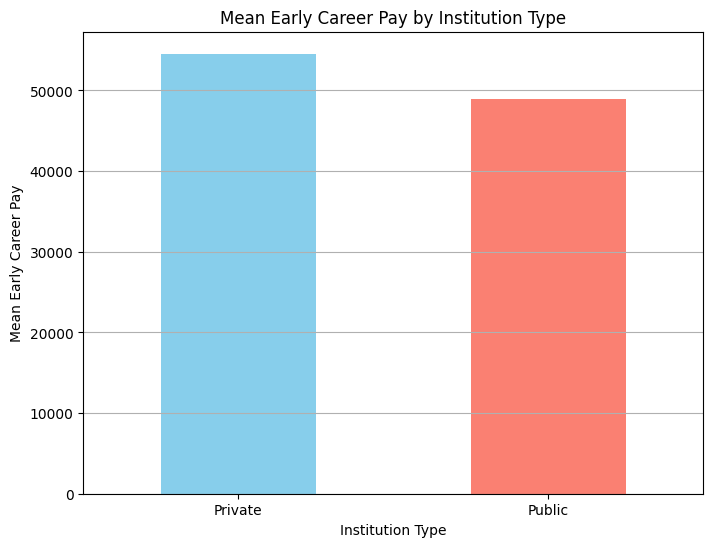

In [20]:
# Calculate mean early career pay by institution type
mean_early_career_pay = college.groupby('type')['early_career_pay'].mean()

# Plotting
plt.figure(figsize=(8, 6))

# Create barplot
mean_early_career_pay.plot(kind='bar', color=['skyblue', 'salmon'])
plt.title('Mean Early Career Pay by Institution Type')
plt.xlabel('Institution Type')
plt.ylabel('Mean Early Career Pay')
plt.xticks(rotation=0)
plt.grid(axis='y')

plt.show()

A scatterplot that shows the relationship between the proportion of women in institutions and early career pay.


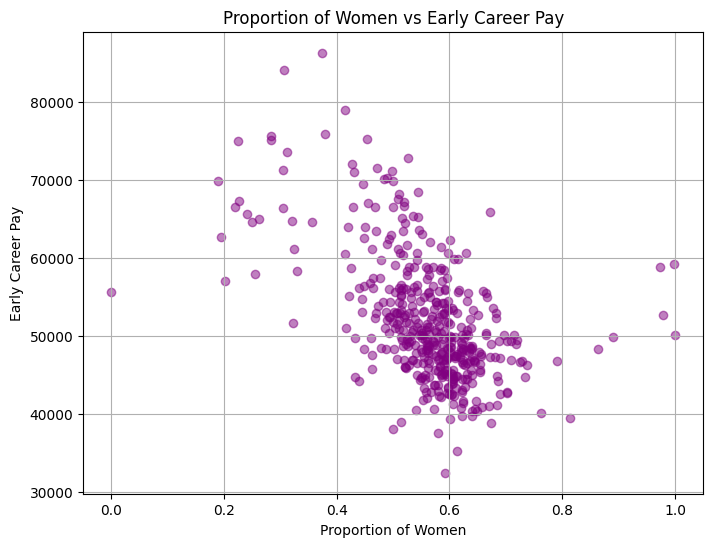

In [21]:
plt.figure(figsize=(8, 6))

# Create scatter plot
plt.scatter(college['women_proportion'], college['early_career_pay'], color='purple', alpha=0.5)
plt.title('Proportion of Women vs Early Career Pay')
plt.xlabel('Proportion of Women')
plt.ylabel('Early Career Pay')
plt.grid(True)

plt.show()

A boxplot used to make comparison of in-state and out-of-state total cost of attendance.

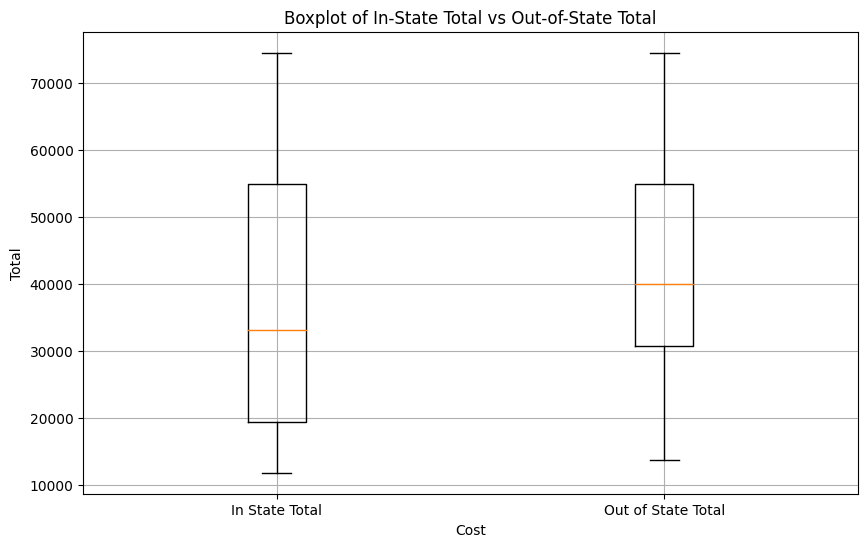

In [22]:
plt.figure(figsize=(10, 6))
plt.boxplot([college['in_state_total'], college['out_of_state_total']], labels=['In State Total', 'Out of State Total'])

# Add labels and title
plt.xlabel('Cost')
plt.ylabel('Total')
plt.title('Boxplot of In-State Total vs Out-of-State Total')

plt.grid(True)
plt.show()

A scatterplot that shows the relationship of early career play and total in-state vs. out-of-state cost.


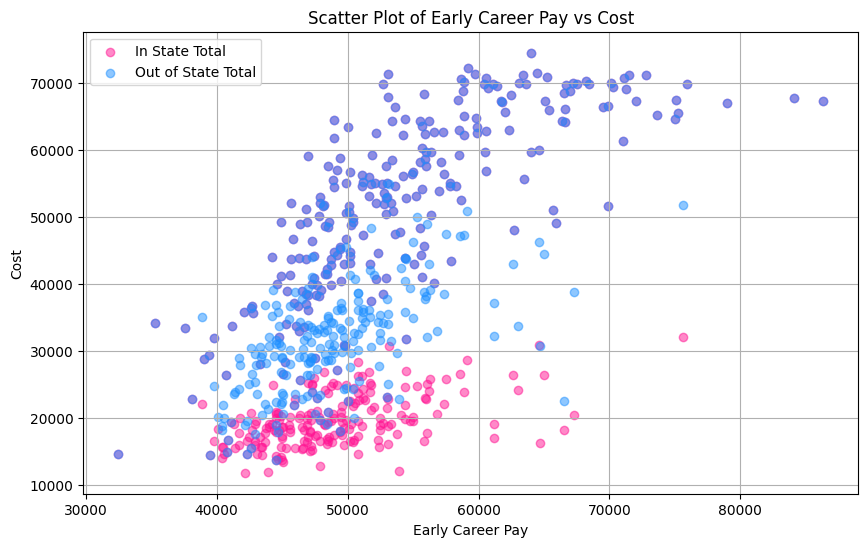

In [23]:
plt.figure(figsize=(10, 6))
plt.scatter(college['early_career_pay'], college['in_state_total'], c='deeppink', label='In State Total', alpha=0.5)
plt.scatter(college['early_career_pay'], college['out_of_state_total'], c='dodgerblue', label='Out of State Total', alpha=0.5)

# Add labels and title
plt.xlabel('Early Career Pay')
plt.ylabel('Cost')
plt.title('Scatter Plot of Early Career Pay vs Cost')
plt.legend()


plt.grid(True)
plt.show()

A pairplot that shows the correlation between all variables in the dataset.

In [24]:
# A pairplot of all variables in the college dataframe
pd.plotting.scatter_matrix(college[['early_career_pay', 'total_enrollment', 'women_proportion', 'foreign_proportion',
       'stem_percent', 'net_cost', 'in_state_total',
       'out_of_state_total', 'type']], figsize = (55,40))

Output hidden; open in https://colab.research.google.com to view.

# Machine Learning Models

1. Ridge regression model

First, define the independent variables and convert the categorical parameter *type* into an indicator variable.

In [41]:
# Define the independent variables
X = college[['women_proportion', 'foreign_proportion',
       'stem_percent', 'in_state_total',
       'out_of_state_total']]
dummy = pd.get_dummies(college[['type']])

X = pd.concat([X, dummy[['type_Private', 'type_Public']]], axis = 1)
X.info()

# response variable
y = college['early_career_pay']

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 444 entries, 0 to 443
Data columns (total 7 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   women_proportion    444 non-null    float64
 1   foreign_proportion  444 non-null    float64
 2   stem_percent        444 non-null    int64  
 3   in_state_total      444 non-null    int64  
 4   out_of_state_total  444 non-null    int64  
 5   type_Private        444 non-null    bool   
 6   type_Public         444 non-null    bool   
dtypes: bool(2), float64(2), int64(3)
memory usage: 18.3 KB


Generate an array of alpha values to use to tune the model. Create a matrix to store ridge regression coefficients associated with each alpha value. Additionally, split the dataset into a training set and a test set and standardize the variables so that they are on the same scale.

In [42]:
alphas = np.logspace(-5,3,30)
print("alpha values: ", alphas)

# Split the dataset into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# scale features
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.fit_transform(X_test)

ridge = Ridge()
train_scores = []  # List to store train scores
test_scores = []   # List to store test scores
MSE = []

for a in alphas:
    ridge.set_params(alpha = a)
    ridge.fit(X_train_scaled, y_train)  # Fit a ridge regression on the training data
    pred = ridge.predict(X_test_scaled) # use the trained model to predict test data

    # Evaluate the model
    # model scores
    train_score = ridge.score(X_train_scaled, y_train)
    test_score = ridge.score(X_test_scaled, y_test)
    train_scores.append(train_score)
    test_scores.append(test_score)


alpha values:  [1.00000000e-05 1.88739182e-05 3.56224789e-05 6.72335754e-05
 1.26896100e-04 2.39502662e-04 4.52035366e-04 8.53167852e-04
 1.61026203e-03 3.03919538e-03 5.73615251e-03 1.08263673e-02
 2.04335972e-02 3.85662042e-02 7.27895384e-02 1.37382380e-01
 2.59294380e-01 4.89390092e-01 9.23670857e-01 1.74332882e+00
 3.29034456e+00 6.21016942e+00 1.17210230e+01 2.21221629e+01
 4.17531894e+01 7.88046282e+01 1.48735211e+02 2.80721620e+02
 5.29831691e+02 1.00000000e+03]


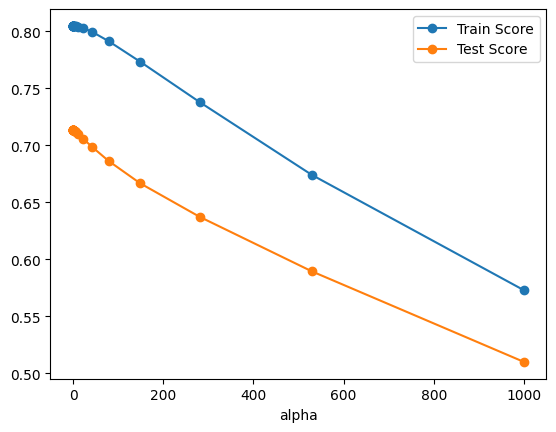

In [43]:
# Plot training and test scores across alpha values
plt.plot(alphas, train_scores, '-o', label='Train Score')
plt.plot(alphas, test_scores, '-o', label='Test Score')
plt.xlabel("alpha")
plt.legend()

According to the training score and test score plot, the ridge regression model performs better with very small alpha values. It is suggesting that the model is performing better with minimal regulation and that the multicollinearity in the dataset is low, the dataset is not very complex, and it is not unstable.

2. Multivariate Linear Regression Model

Refering to the **Covariance** Matrix earlier, we decided to drop *net_cost* and *total_enrollment* since they have weak correlation to *early_career_pay*.

In [32]:
X = college[['women_proportion', 'foreign_proportion',
       'stem_percent', 'in_state_total',
       'out_of_state_total']]

X = pd.concat([X, dummy[['type_Private', 'type_Public']]], axis = 1)

# Train model
model = LinearRegression()
model.fit(X, y)

# Predict
y_pred = model.predict(X)

# Calculate MSE and R2 scores
MSE = mean_squared_error(y, y_pred)
R2 = r2_score(y, y_pred)

# Print MSE and R2 scores
print("MSE:", MSE)
print("R2:", R2)

MSE: 13155129.575161781
R2: 0.7981631917791661


3. Regression Tree Model

In [33]:
# narrow down the variables
# exclude 'net_cost' and 'total_enrollment' as they have  weaker correlations
# including both 'in_state_total' and 'out_of_state_total' total costs, 'net_cost' may not add much additional information to the model. it's redundant
new_college = college.drop(['net_cost', 'total_enrollment'], axis=1)
new_college.head()

,name,early_career_pay,stem_percent,women_proportion,foreign_proportion,type,in_state_total,out_of_state_total
0,Auburn University,54400,31,0.493902,0.055071,Public,24608,43856
1,Tuskegee University,54500,30,0.597809,0.006445,Private,31820,31820
2,Samford University,48400,3,0.624772,0.031016,Private,42200,42200
3,University of Alabama at Birmingham,48600,17,0.603701,0.035565,Public,17110,31030
4,University of South Alabama,47700,17,0.613730,0.042202,Public,17490,27360


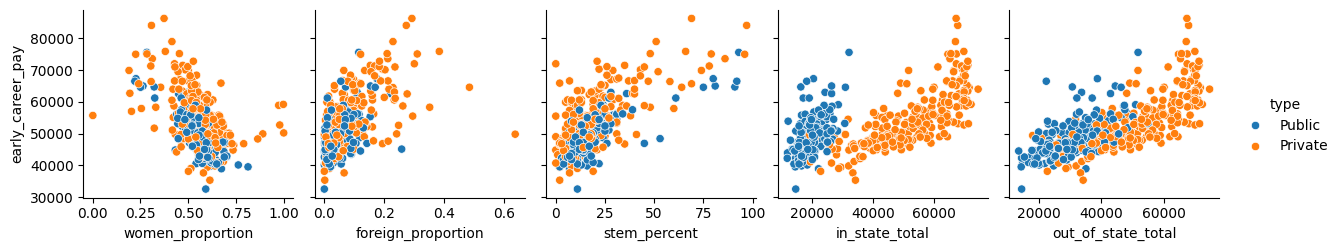

In [34]:
# A pairplot with each plot comparing 'Early Career Pay' against the independent variables while distinguishing between different types of colleges (public, private)
seaborn.pairplot(new_college, y_vars = ['early_career_pay'], x_vars = ['women_proportion', 'foreign_proportion',
       'stem_percent', 'in_state_total', 'out_of_state_total'], hue = 'type')

In [35]:
## Handling Categorical Features

# all variables in college table
print(new_college.keys())

# 'type' is the only categorical parameter
print(new_college['type'].head())

# create label encoder object
label_encoder = preprocessing.LabelEncoder()

# Encode labels in column 'type'
# if public, label = 1, and 0 otherwise
new_college['type'] = label_encoder.fit_transform(new_college['type'])
new_college['type'].head()

Index(['name', 'early_career_pay', 'stem_percent', 'women_proportion',
       'foreign_proportion', 'type', 'in_state_total', 'out_of_state_total'],
      dtype='object')
0     Public
1    Private
2    Private
3     Public
4     Public
Name: type, dtype: object


0    1
1    0
2    0
3    1
4    1
Name: type, dtype: int64

In [45]:
np.random.seed(42)

# Split dataset into parameters (X) and predictor (y)
X = new_college[['women_proportion', 'stem_percent', 'type','in_state_total', 'out_of_state_total', 'foreign_proportion']]
y = new_college['early_career_pay']

# Split the dataset into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Define a range of max depths to test
max_depths = range(1, 21)  # Example: Test depths from 1 to 20

# Initialize lists to store training and testing errors
train_errors = []
test_errors = []

train_r2_scores = []
test_r2_scores = []

# Iterate over different max depths

for max_depth in max_depths:
    # Instantiate the decision tree regressor model with the current max depth
    model = DecisionTreeRegressor(max_depth=max_depth)

    # Fit the model to the training data
    model.fit(X_train, y_train)

    # Predict on the training and testing data
    y_train_pred = model.predict(X_train)
    y_test_pred = model.predict(X_test)

    # Calculate training and testing errors (MSE)
    train_error = mean_squared_error(y_train, y_train_pred)
    test_error = mean_squared_error(y_test, y_test_pred)

    # Calculate R-squared for training and testing data
    train_r2 = r2_score(y_train, y_train_pred)
    test_r2 = r2_score(y_test, y_test_pred)

    # Append errors to the lists
    train_errors.append(train_error)
    test_errors.append(test_error)

    # Append R-squared scores to the lists
    train_r2_scores.append(train_r2)
    test_r2_scores.append(test_r2)

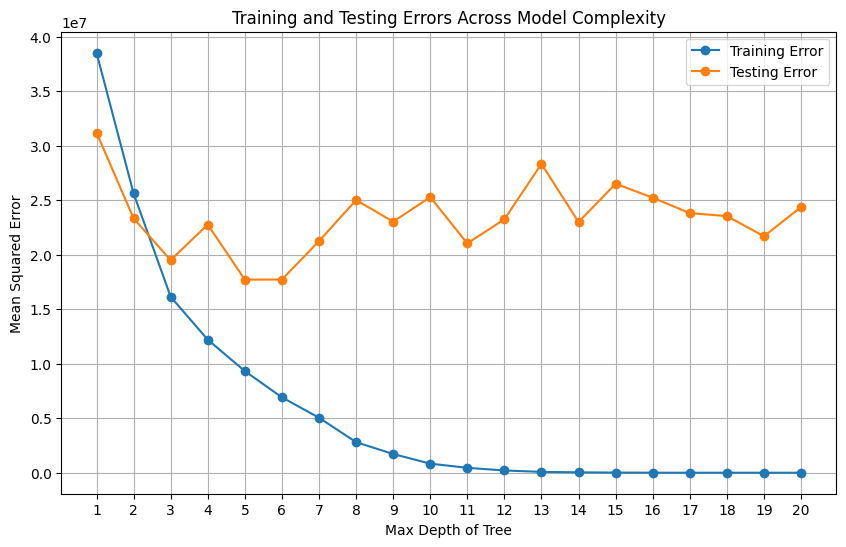

In [37]:
# Plotting MSE
plt.figure(figsize=(10, 6))
plt.plot(max_depths, train_errors, label='Training Error', marker='o')
plt.plot(max_depths, test_errors, label='Testing Error', marker='o')
plt.xlabel('Max Depth of Tree')
plt.ylabel('Mean Squared Error')
plt.title('Training and Testing Errors Across Model Complexity')
plt.xticks(max_depths)
plt.legend()
plt.grid(True)
plt.show()

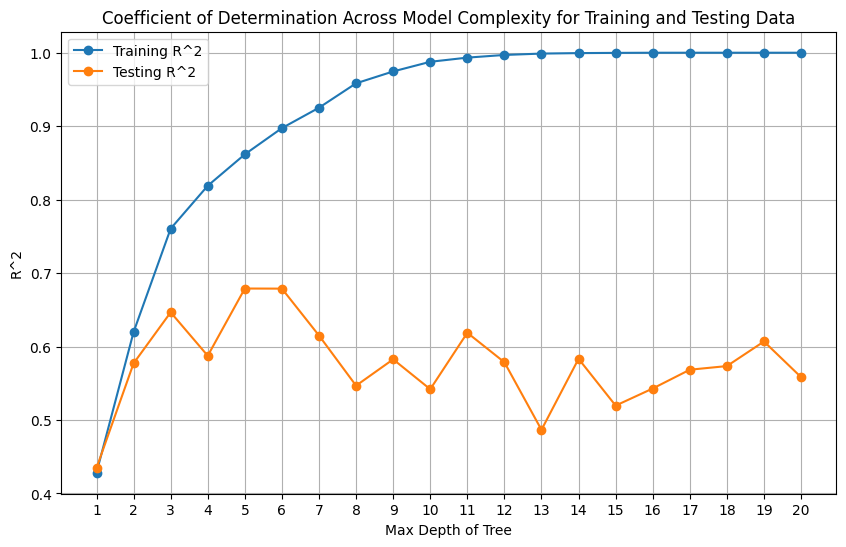

In [46]:
# Plotting R-squared
plt.figure(figsize=(10, 6))
plt.plot(max_depths, train_r2_scores, label='Training R^2', marker='o')
plt.plot(max_depths, test_r2_scores, label='Testing R^2', marker='o')
plt.xlabel('Max Depth of Tree')
plt.ylabel('R^2')
plt.title('Coefficient of Determination Across Model Complexity for Training and Testing Data')
plt.xticks(max_depths)
plt.legend()
plt.grid(True)
plt.show()

In [48]:
# final model with maximum depth of 4
final_model = DecisionTreeRegressor(max_depth=4)

# Fit the model to the training data
final_model.fit(X_train, y_train)

# Predict on the training and testing data
y_train_pred = final_model.predict(X_train)
y_test_pred = final_model.predict(X_test)

# Calculate training and testing errors (MSE)
train_error = mean_squared_error(y_train, y_train_pred)
test_error = mean_squared_error(y_test, y_test_pred)

print("Mean Squared Error:", test_error)

# R^2 for regression tree model with max depth of 4

print("R^2: ", test_r2_scores[3])

Mean Squared Error: 22763805.71424268
R^2:  0.5874594229347088


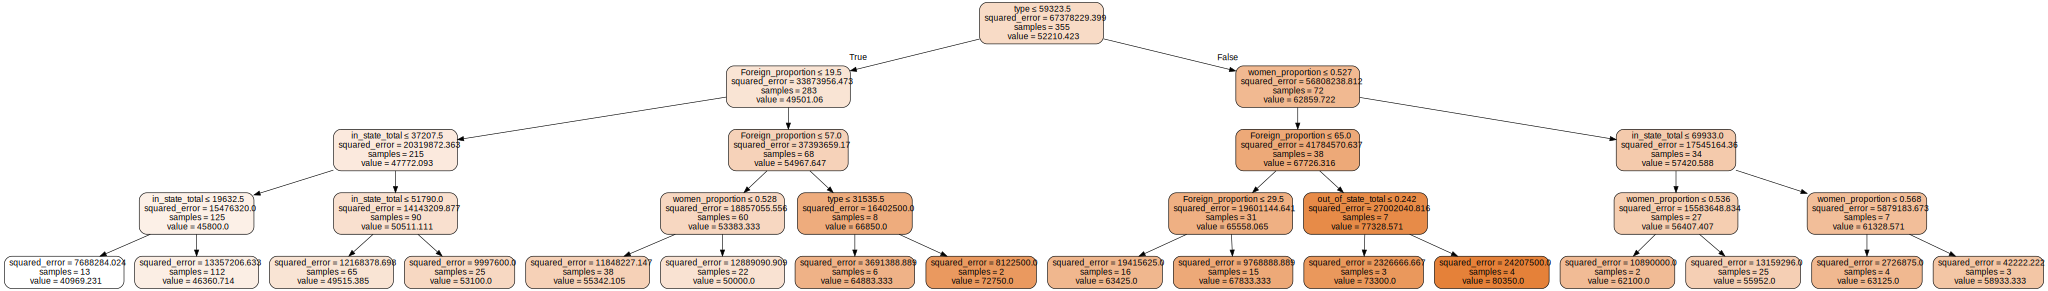

In [39]:
dot_data = tree.export_graphviz(final_model, out_file = None,
                     feature_names= ['women_proportion',  'Foreign_proportion' , 'stem_percent', 'type',
       'in_state_total', 'out_of_state_total'],
                     class_names= new_college[['early_career_pay']],
                     filled=True, rounded=True,
                     special_characters=True)
graph = graphviz.Source(dot_data)
graph

The MSE for the multivariate linear regression model is smaller that that of the regression tree model. That is, the multivariate linear model was better in predicting starting salary of graduates based on the parameters than the regression tree.